<a href="https://colab.research.google.com/github/cbishop4/MSE7530/blob/main/Assignment3_Preview20250921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
**This is just a preview of Assignment 3 that will be officially assigned on Monday Sept 22nd or Tuesday Sept 23rd. I wanted you to have it in your hands before class on Monday so you know what to focus on.**  
MSE 7530, Fall 2025, Wayne State University  
Prof. Camille Bishop

<font size=4>This assignment focuses on peak finding, data smoothing, and fitting data to equations. I have left the original text from the lecture too. We will cover three physical techniques:  
1. X-ray Diffraction
2. Raman
3. ATR-FTIR

<font size=4><font color='blue'>The topics today are broadly referred to as "signal processing". </font> Monday, we will bring in some physical techniques to expand your materials characterization toolbox.

## <font color='red'>**(Always Run These First)**</font> Part 0.5: Quick refresher and necessary import cells
Every notebook will generally start with all the necessary import cells in one place; here I will import all packages that we used at once.

In [ ]:
# the standard cell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Setting up file access to the class GH Repo and your personal Google Drive

In [ ]:
!git clone https://github.com/cbishop4/MSE7530.git
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MSE7530'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 174 (delta 69), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (174/174), 7.80 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Mounted at /content/drive


## New Python Concept - Input cells
To make the class less reliant on programming, I'm trying to adopt some tools to make this easier. The first of these is "input cells". When you run these, a box will pop up and you can enter the value. Try the example below:

In [ ]:
a = int(input('Enter a value to multiply by 3: '))
result = a*3
print(result)

Enter a value to multiply by 3: 3
9


When you run the cell, it will pause the execution and wait for you to put in a value in a box that pops up in the output area. Type the value in the box and hit "enter", and the cell will continue running. Note that above I have int(input()); this means that the input needs to be an integer. Alternatively, if I specify the type as "float", it will accept either an integer or a decimal number (and treat it as a decimal)

In [ ]:
a = float(input('Enter a value to multiply by 3: '))
result = a*3
print(result)

Enter a value to multiply by 3: 4
12.0


This can be used for anything; this way, rather than having to insert code directly into a line, you can enter it and have it automatically populate.

## Scientific Python (SciPy) Introduction & Importing
<font size=4>SciPy is an open-source software heavily used in mathematics, science, and engineering. Since it is so widely used, it has very thorough documentation and support: https://docs.scipy.org/doc/scipy/index.html. It is generally pre-installed in most Python distributions, including Colab, so it doesn't have to be pip installed unless you need a specific version. While you could import scipy like so:

```
import scipy as sp
```
<font size=4>However, instead people generally import specific modules from scipy as in the below code cell:



In [ ]:
from scipy import signal

<font size=4>Today we will be working with the signal processing module. Take a look around the documentation for other modules. We will use many modules through the course of the class.



## Part 1: Finding Peaks

### signal.find_peaks

<font size=4>At its base, this function uses a simple algorithm to identify peaks: It returns a peak for every location in which a point is higher than both of its neighbors.

<font size=4>First, let's just use find_peaks on a dataset to see what find_peaks will do with no control.

*I have generated "array1D" using Gemini's auto-generation, by entering the prompt "generate a noisy signal with several peaks"

Text(0, 0.5, 'Intensity')

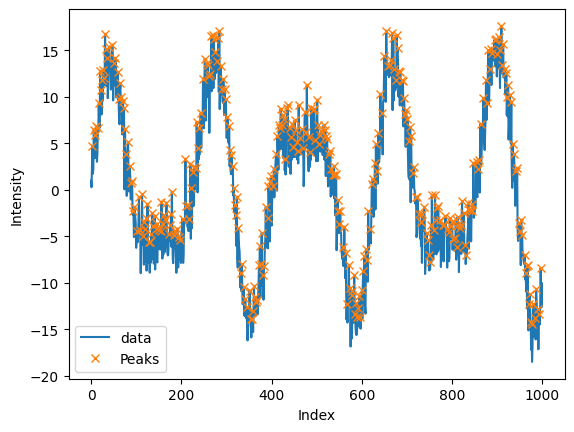

In [ ]:
# generate a noisy signal with several peaks
np.random.seed(42)  # for reproducibility
x = np.linspace(0, 10, 1000)
array1D = (np.sin(x * 3) + 0.5 * np.sin(x * 5) + 0.2 * np.random.randn(len(x))) * 10
plt.plot(array1D,label='data')
peak_locs = signal.find_peaks(array1D)
plt.plot(peak_locs[0], array1D[peak_locs[0]], 'x',label='Peaks')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Intensity')

<font color='red'><font size=4> If the above blue signal is experimental data, is calling "find_peaks" alone going to be a good choice for interpretation?

<font size=4> See powerpoint for explanation

<font size=4> A fundamental look at the function - our "basic implementation"

In [ ]:
np.random.seed(31)
basic_data = (np.random.rand(10)*10).astype(int)
print(basic_data)
output = signal.find_peaks(basic_data)
print(output)

[2 9 7 9 2 1 9 0 0 5]
(array([1, 3, 6]), {})


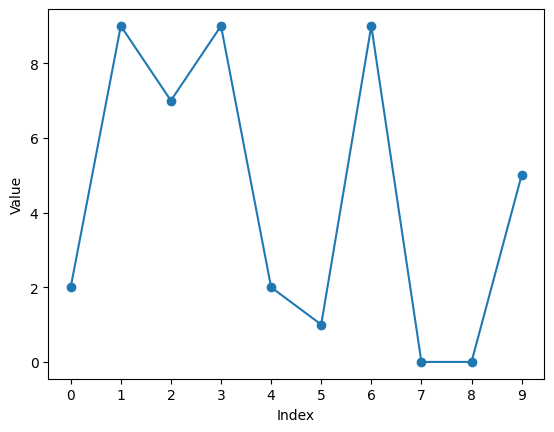

In [ ]:
plt.plot(basic_data,'-o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(np.linspace(0,9,10))
plt.show()

<font size=4>We are going to look at the absolute base algorithm for this function to understand what it's doing. As you'll see, we can add aspects later to refine. What we are about to go through is hidden a few layers into the source code; don't worry about exactly where it is. **Goal: to build your algorithmic thinking skills and understand how code processes data, and how that influences your interpretation.** Here, I have written the un-commented code that you would use to find these peaks. I will go through the code line-by-line on the board. I recommend that you do one of two things:  
1. Write comments (starting with #) directly on the code below, or  
2. Take notes with paper and pencil  
<font size=4>Figure out which of these methods is better for your own learning style.

<font size=4><font color='blue'> NOTE: The code below has been substantially modified from its original form. Its original form is written to interface with other functions and C, the programming language that is one step closer to "computer-speak". It is re-written here at a level appropriate for this class.

In [ ]:
x = array1D #the array on which we will find peaks

midpoints = np.empty(0,dtype=int)
left_edges = np.empty(0,dtype=int)
right_edges = np.empty(0, dtype=int)

i = 1  # Pointer to current sample, first one can't be maxima
i_max = x.shape[0] - 1  # Last sample can't be maxima
while i < i_max:
    # Test if previous sample is smaller
    if x[i - 1] < x[i]:
        i_ahead = i + 1  # Index to look ahead of current sample

        # Find next sample that is unequal to x[i]
        while i_ahead < i_max and x[i_ahead] == x[i]:
            i_ahead += 1

        # Maxima is found if next unequal sample is smaller than x[i]
        if x[i_ahead] < x[i]:
            left_edges = np.append(left_edges,i)
            right_edges = np.append(right_edges,i_ahead-1)
            midpoints = np.append(midpoints, (i + i_ahead - 1) // 2)

            # Skip samples that can't be maximum
            i = i_ahead
    i += 1

<font size=4> Double-check that our code reproduces the results from find_peaks (confirm that we rewrote our algorithm correctly)

(400.0, 600.0)

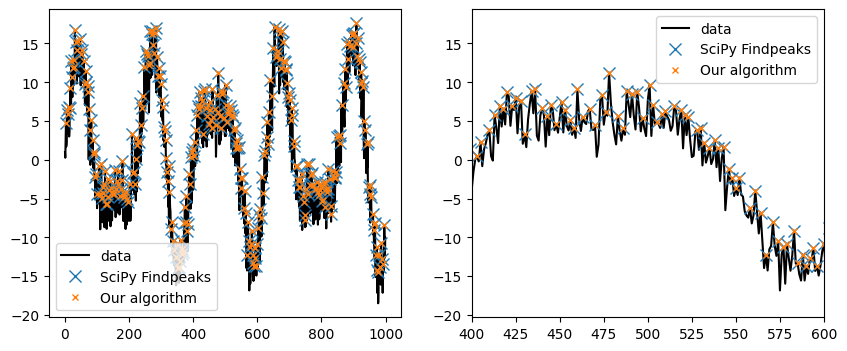

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
for a in ax:
  a.plot(array1D,label='data',color='k')
  a.plot(peak_locs[0], array1D[peak_locs[0]], 'x',label='SciPy Findpeaks',markersize=8)
  a.plot(midpoints,array1D[midpoints],'x',label='Our algorithm',markersize=5)
  a.legend()
ax[1].set_xlim(400,600)

### <font color='blue'>Additional find_peaks arguments:
<font size=4> Many Python functions/modules have many arguments which are default specified. As an example, here is what the documentation for "find_peaks" has:

```
find_peaks(x, height=None, threshold=None, distance=None, prominence=None,
width=None, wlen=None, rel_height=0.5, plateau_size=None)
```
<font size=4>The function find_peaks has 9 arguments. However, only one argument **needs** to be passed, which is the array on which to find peaks. The rest of the arguments all have **default values** which are set in the definition of the function with = signs. If nothing is entered for these, the code will run whatever the default is. (Note that arguments are often called parameters interchangeably)

For the remainder of these exercises, we will use smoother experimental data where these will make more sense.

In [ ]:
# The data we worked with Monday/you're using in your assignment (not background subtracted)
file_PS = '/content/MSE7530/sampledata/Polystyrene.csv'
file_bg = '/content/MSE7530/sampledata/BackgroundSpectrum.csv'
PS_loaded = pd.read_csv(file_PS,header=0)
bg_loaded = pd.read_csv(file_bg,header=0)

(3201.306, 470.5533)

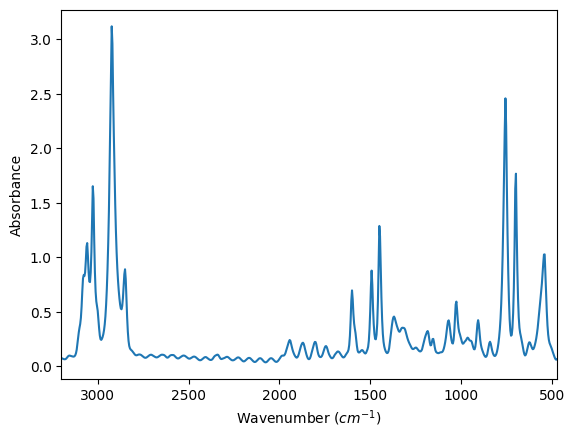

In [ ]:
finalspec = -np.log10(PS_loaded['Intensity']/bg_loaded['Intensity'])
wns = PS_loaded['Wavenumber']
plt.plot(wns,finalspec)
plt.xlabel('Wavenumber $(cm^{-1})$')
plt.ylabel('Absorbance')
plt.xlim(np.max(wns),np.min(wns)) # switching wavenumber display to standard convention


We now have something more reasonable to find peaks on, where things will make a difference.

Text(0, 0.5, 'Intensity')

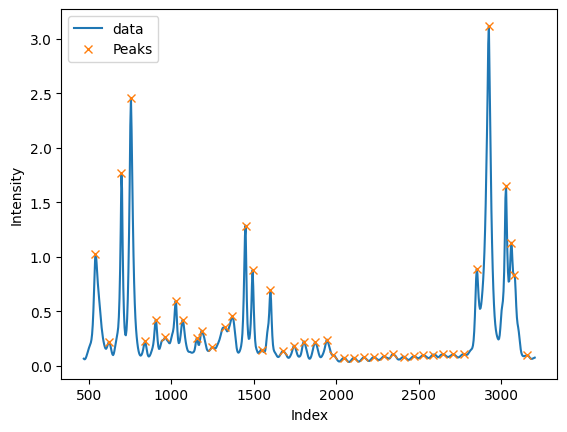

In [ ]:
plt.plot(wns,finalspec,label='data')
peak_tuple = signal.find_peaks(finalspec)
plt.plot(wns[peak_tuple[0]], finalspec[peak_tuple[0]], 'x',label='Peaks')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Intensity')

#### <font color='blue'>"Distance" parameter

Distance 1 to test: 3
Distance 2 to test: 4
Distance 3 to test: 2


(3201.306, 470.5533)

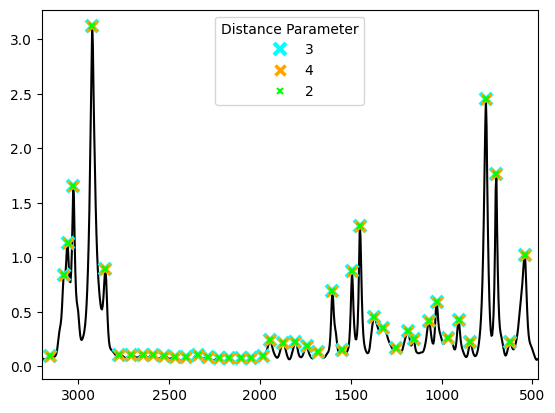

In [ ]:
plt.plot(wns,finalspec,color='k')
d = int(input('Distance 1 to test: '))
peak_locs = signal.find_peaks(finalspec,distance=d)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=d,markersize=9,markeredgewidth=3,color='cyan')
d = int(input('Distance 2 to test: '))
peak_locs = signal.find_peaks(finalspec,distance=d)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=d,markersize=7,markeredgewidth=2.5,color='orange')
d = int(input('Distance 3 to test: '))
peak_locs = signal.find_peaks(finalspec,distance=d)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=d,markersize=5,markeredgewidth=1.5,color='lime')
plt.legend(title='Distance Parameter')
plt.xlim(np.max(wns),np.min(wns))

<font color='red'> Play around with the above distance parameters until you settle on three that seem to show meaningful difference in their behavior. Is the distance parameter a good parameter to change to filter for meaningful peaks in this system? Why or why not? You may find it helpful to refer to the documentation to learn how this algorithm works in plain terms.

<font color='red'> Your answer here

#### Threshold Parameter
<font color='red'> Test three parameters for threshold that yield peaks.

Threshold 1 to test: 2
Threshold 2 to test: 3
Threshold 3 to test: 4


(3201.306, 470.5533)

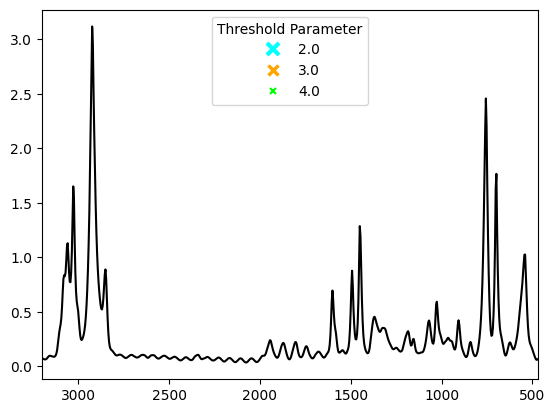

In [ ]:
plt.plot(wns,finalspec,color='k')
t = float(input('Threshold 1 to test: '))
peak_locs = signal.find_peaks(finalspec,threshold=t)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=t,markersize=9,markeredgewidth=3,color='cyan')
t = float(input('Threshold 2 to test: '))
peak_locs = signal.find_peaks(finalspec,threshold=t)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=t,markersize=7,markeredgewidth=2.5,color='orange')
t = float(input('Threshold 3 to test: '))
peak_locs = signal.find_peaks(finalspec,threshold=t)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=t,markersize=5,markeredgewidth=1.5,color='lime')
plt.legend(title='Threshold Parameter')
plt.xlim(np.max(wns),np.min(wns))

#### Prominence
<font color='red'> Test three parameters for prominence that yield peaks.

Prominence 1 to test: 3
Prominence 2 to test: 4
Prominence 3 to test: 2


(3201.306, 470.5533)

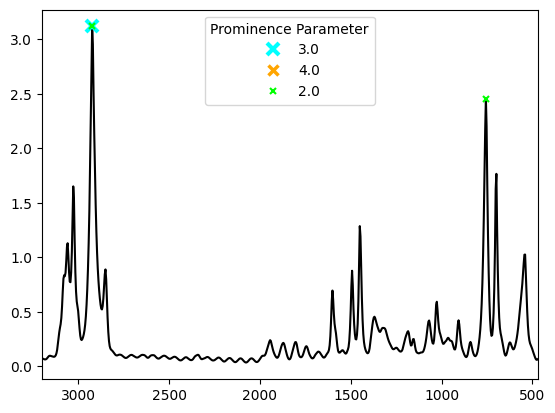

In [ ]:
plt.plot(wns,finalspec,color='k')
p = float(input('Prominence 1 to test: '))
peak_locs = signal.find_peaks(finalspec,prominence=p)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=p,markersize=9,markeredgewidth=3,color='cyan')
p = float(input('Prominence 2 to test: '))
peak_locs = signal.find_peaks(finalspec,prominence=p)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=p,markersize=7,markeredgewidth=2.5,color='orange')
p = float(input('Prominence 3 to test: '))
peak_locs = signal.find_peaks(finalspec,prominence=p)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=p,markersize=5,markeredgewidth=1.5,color='lime')
plt.legend(title='Prominence Parameter')
plt.xlim(np.max(wns),np.min(wns))

#### Width
<font color='red'> Test three parameters for width that yield peaks.

Width 1 to test: 4
Width 2 to test: 2
Width 3 to test: 3


(3201.306, 470.5533)

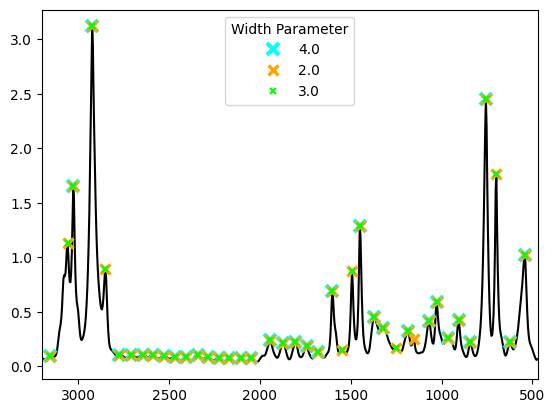

In [ ]:
plt.plot(wns,finalspec,color='k')
w = float(input('Width 1 to test: '))
peak_locs = signal.find_peaks(finalspec,width=w)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=w,markersize=9,markeredgewidth=3,color='cyan')
w = float(input('Width 2 to test: '))
peak_locs = signal.find_peaks(finalspec,width=w)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=w,markersize=7,markeredgewidth=2.5,color='orange')
w = float(input('Width 3 to test: '))
peak_locs = signal.find_peaks(finalspec,width=w)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',label=w,markersize=5,markeredgewidth=1.5,color='lime')
plt.legend(title='Width Parameter')
plt.xlim(np.max(wns),np.min(wns))

### <font color='red'> Putting it together - finding the right combination
<font color='red'>Experiment with different combinations of parameters for find_peaks. Which ones seem to be the most useful? Which are not useful for this data set, and why? When you're all done, do you think you've done a sufficient job fitting the dataset, or would you want to look for another tool?

Here I have not used the input cells because they're difficult to implement with the flexibility I want you to have for this exercise. Enter the variable you want on each line; if you do not want to use a variable, type None. It should turn blue.

Text(0.5, 1.0, 'Width = None, Prominence = None, Height = None, Threshold = None')

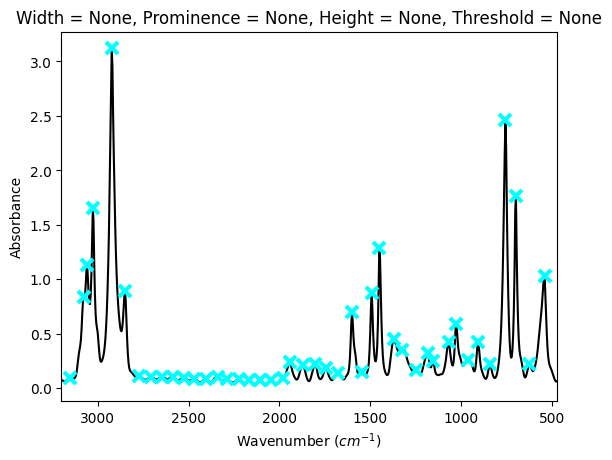

In [ ]:
plt.plot(wns,finalspec,color='k')
w = None
p = None
h = None
t = None
peak_locs = signal.find_peaks(finalspec,width=w,prominence=p,height=h,threshold=t)
plt.plot(wns[peak_locs[0]], finalspec[peak_locs[0]], 'x',markersize=9,markeredgewidth=3,color='cyan')
plt.xlabel('Wavenumber $(cm^{-1})$')
plt.ylabel('Absorbance')
plt.xlim(np.max(wns),np.min(wns))
plt.title(f'Width = {w}, Prominence = {p}, Height = {h}, Threshold = {t}')

<font color='red'>Think about if you were to use find_peaks to automatically match new spectra to literature values. What difficulties might you encounter?

## <font color='blue'>Part 2: Data Smoothing
<font size=4> Smooth data is best for find_peaks. For example, you can see that the FTIR data from last week (which you just used) is better for finding peaks than the artificial noisy data generated.

In [ ]:
# The data we worked with Monday/you're using in your assignment (not background subtracted)
file_PS = '/content/MSE7530/sampledata/Polystyrene.csv'
PS_loaded = pd.read_csv(file_PS,header=0)

Text(0, 0.5, 'Intensity/Transmission')

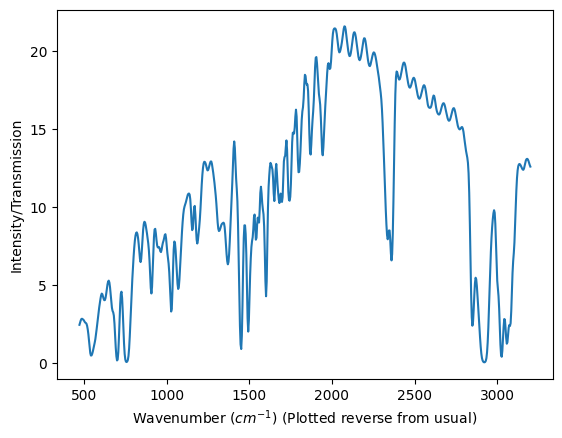

In [ ]:
plt.plot(PS_loaded['Wavenumber'],PS_loaded['Intensity'])
plt.xlabel('Wavenumber $(cm^{-1})$ (Plotted reverse from usual)')
plt.ylabel('Intensity/Transmission')

We need to transform it into something where peaks are maxima (you're welcome for most of the answer to one of the assignment 2 questions)

Text(0, 0.5, 'Absorbance')

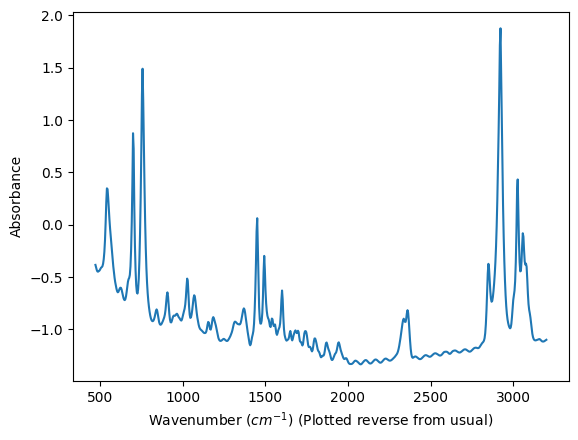

In [ ]:
absorbance = np.log10(1/(PS_loaded['Intensity']))
plt.plot(PS_loaded['Wavenumber'],absorbance)
plt.xlabel('Wavenumber $(cm^{-1})$ (Plotted reverse from usual)')
plt.ylabel('Absorbance')

Clearly there are some issues without the background subtraction - but you can make a few thresholding choices in find_peaks and get a pretty good answer:

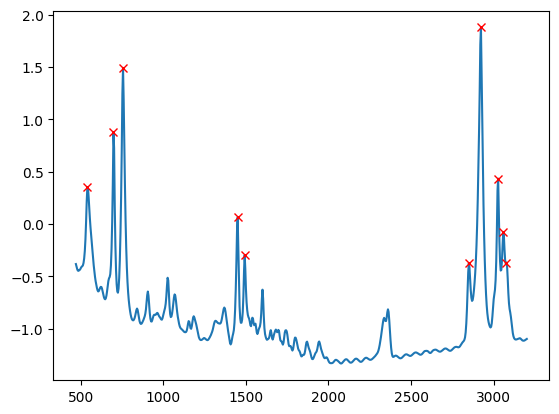

In [ ]:
peaks_FTIR = signal.find_peaks(absorbance,height=-0.5)
plt.plot(PS_loaded['Wavenumber'],absorbance)
plt.plot(PS_loaded['Wavenumber'][peaks_FTIR[0]],absorbance[peaks_FTIR[0]],'x',color='red')

Without background subtraction, the height threshold is harder to use; you can practice optimizing this with your background-subtracted data from assignment 2, and with other parameters.

### Pre-processing: Smoothing
<font size=4>One issue with find_peaks is that it only looks quite locally for maxima. One approach to addressing this is to smooth the data. Today we will work with a Savitzky-Golay Smoothing filter. In your homework, you will experiment with different filters.

#### Simplest filter: Moving average filter  
<font size=4> Let's work with a smaller amount of data for the sake of illustration

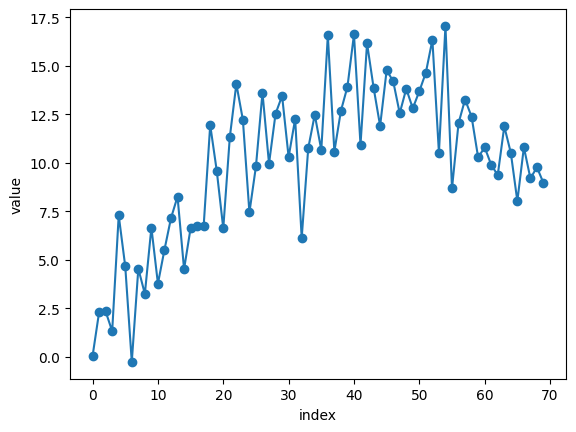

In [ ]:
extra_zoom = array1D[230:300] # takes only the first 30 points of the array
plt.plot(extra_zoom,'-o')
plt.xlabel('index')
plt.ylabel('value')
plt.show()

We can clearly see that there is a trend, but find_peaks would grab some peaks that are really just noise. Let's zoom in even further to illustrate a moving average.

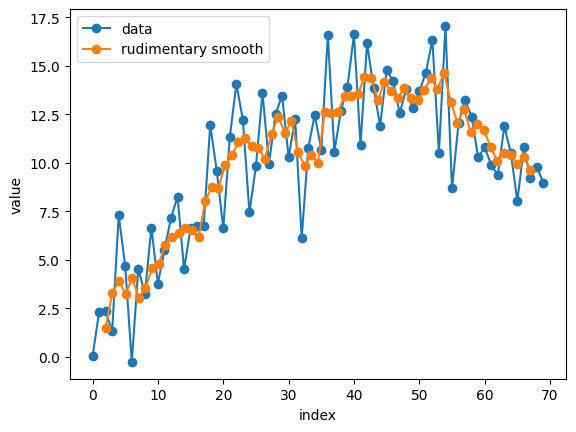

In [ ]:
# code to compute averages; cannot do for the first 2 and last 2 data points
averages = np.empty(len(extra_zoom)-5)
for x in range(2,len(extra_zoom)-3):
  averages[x-2] = np.mean(extra_zoom[x-2:x+2])
plt.plot(extra_zoom,'-o',label='data')
x_averages = np.linspace(2,len(averages)+2,len(averages))
plt.plot(x_averages,averages,'-o',label='rudimentary smooth')
plt.xlabel('index')
plt.ylabel('value')
plt.legend()


This is the process of smoothing, though as you can see, it's not very sophisticated and could be very improved

#### Scipy Function: Savitzky-Golay Filter
A more standard, sophisticated filter is the Savitzky-Golay Filter, which uses local polynomial fits. It has three main parameters: your data, the window length, and the polynomial order

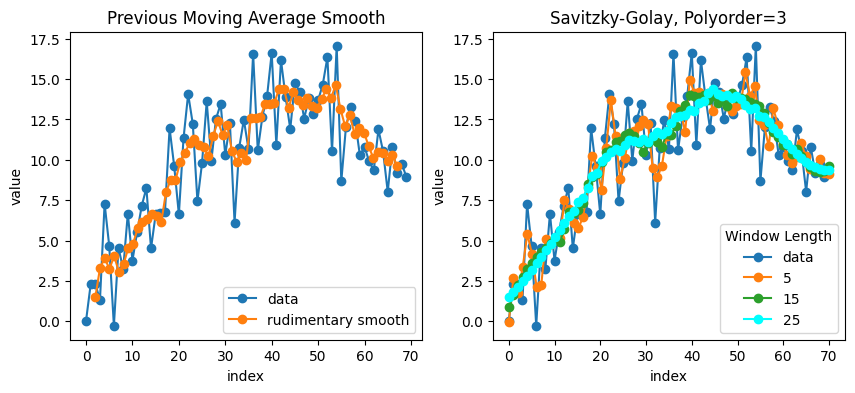

In [ ]:
# changing window length
sg_smoothed1 = signal.savgol_filter(extra_zoom,window_length=5,polyorder=3)
sg_smoothed2 = signal.savgol_filter(extra_zoom,window_length=15,polyorder=3)
sg_smoothed3 = signal.savgol_filter(extra_zoom,window_length=25,polyorder=3)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(extra_zoom,'-o',label='data')
ax[0].plot(x_averages,averages,'-o',label='rudimentary smooth')

ax[1].plot(extra_zoom,'-o',label='data')
index_vals = np.linspace(0,len(sg_smoothed1),len(sg_smoothed1))
ax[1].plot(index_vals,sg_smoothed1,'-o',label='5')
ax[1].plot(index_vals,sg_smoothed2,'-o',label='15')
ax[1].plot(index_vals,sg_smoothed3,'-o',label='25',color='cyan')

ax[0].set_title('Previous Moving Average Smooth')
ax[1].set_title('Savitzky-Golay, Polyorder=3')
ax[0].legend()
ax[1].legend(title='Window Length')
for a in ax:
  a.set_xlabel('index')
  a.set_ylabel('value')

<font color='red'> Which window length seems best?  
Your turn: experiment with polynomial order. Copy-paste the above code, and change the polynomial orders while keeping a constant window length.

In [ ]:
# your code here

Now, let's try it for the full dataset:

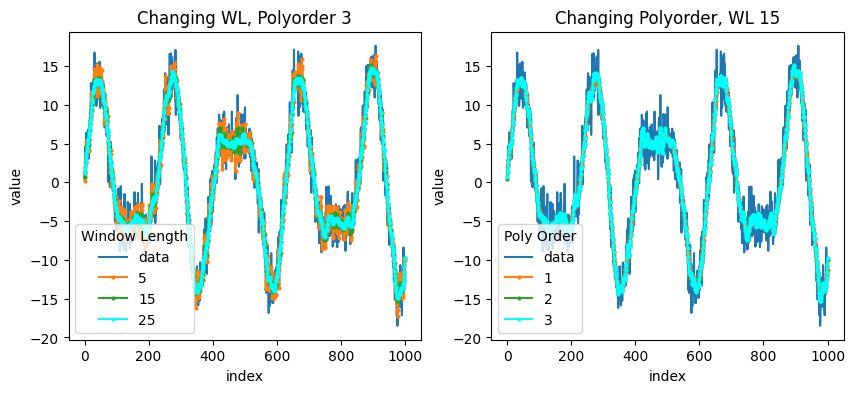

In [ ]:
sg_smoothed1 = signal.savgol_filter(array1D,window_length=5,polyorder=3)
sg_smoothed2 = signal.savgol_filter(array1D,window_length=15,polyorder=3)
sg_smoothed3 = signal.savgol_filter(array1D,window_length=25,polyorder=3)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(array1D,label='data')
index_vals = np.linspace(0,len(sg_smoothed1),len(sg_smoothed1))
ax[0].plot(index_vals,sg_smoothed1,'-o',markersize=2,label='5')
ax[0].plot(index_vals,sg_smoothed2,'-o',markersize=2,label='15')
ax[0].plot(index_vals,sg_smoothed3,'-o',markersize=2,label='25',color='cyan')

sg_smoothed1 = signal.savgol_filter(array1D,window_length=15,polyorder=1)
sg_smoothed2 = signal.savgol_filter(array1D,window_length=15,polyorder=2)
sg_smoothed3 = signal.savgol_filter(array1D,window_length=15,polyorder=3)

ax[1].plot(array1D,label='data')
index_vals = np.linspace(0,len(sg_smoothed1),len(sg_smoothed1))
ax[1].plot(index_vals,sg_smoothed1,'-o',markersize=2,label='1')
ax[1].plot(index_vals,sg_smoothed2,'-o',markersize=2,label='2')
ax[1].plot(index_vals,sg_smoothed3,'-o',markersize=2,label='3',color='cyan')



ax[0].set_title('Changing WL, Polyorder 3')
ax[1].set_title('Changing Polyorder, WL 15')
ax[0].legend()
ax[0].legend(title='Window Length')
ax[1].legend(title='Poly Order')
for a in ax:
  a.set_xlabel('index')
  a.set_ylabel('value')

## Part 3: Case study and categorization
* In Progress

In [ ]:
df_dict = pd.read_excel('/content/drive/MyDrive/XRD_KarapinSpringorum.xlsx',sheet_name=None)
del(df_dict['Final All'])
for k in df_dict.keys():
  df_dict[k] = df_dict[k].rename(columns={df_dict[k].columns[0] : "2theta", df_dict[k].columns[1] : "dspacing",
                                     df_dict[k].columns[2] : "Raw", df_dict[k].columns[3] : "Background", df_dict[k].columns[4] : "Final"})

Text(0.5, 1.0, 'Background')

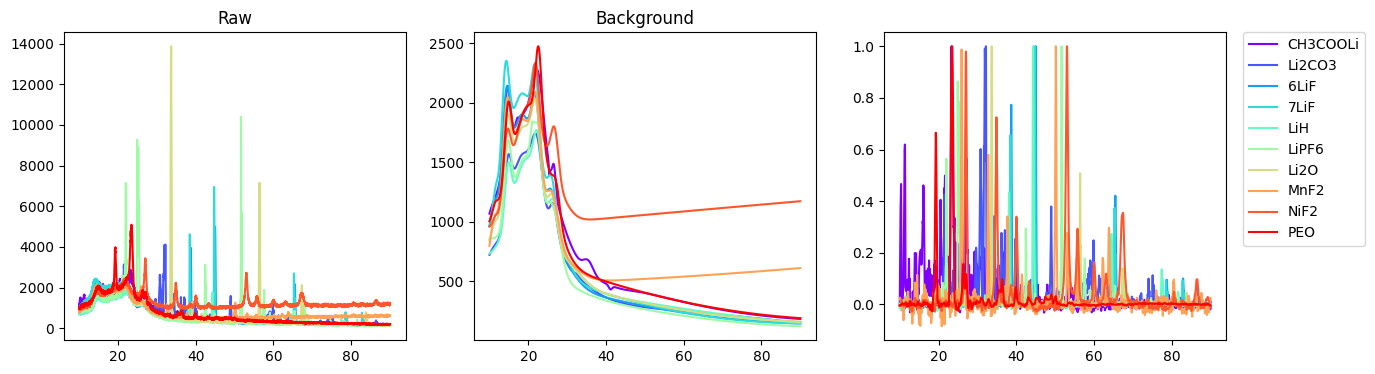

In [ ]:
from matplotlib.pyplot import cm
pcol = iter(cm.rainbow(np.linspace(0,1,len(df_dict.keys()))))
fig, ax = plt.subplots(1,3,figsize=(15,4))
for k in df_dict.keys():
  cc = next(pcol)
  ax[0].plot(df_dict[k]['2theta'],df_dict[k]['Raw'],color=cc)
  ax[1].plot(df_dict[k]['2theta'],df_dict[k]['Background'],color=cc)
  ax[2].plot(df_dict[k]['2theta'],df_dict[k]['Final'],color=cc,label=k)

ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[0].set_title('Raw')
ax[1].set_title('Background')

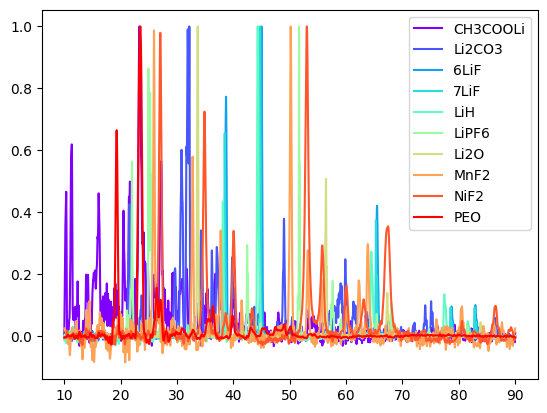

In [ ]:
fig, ax = plt.subplots()
pcol = iter(cm.rainbow(np.linspace(0,1,len(df_dict.keys()))))
for k in df_dict.keys():
  ax.plot(df_dict[k]['2theta'],df_dict[k]['Final'],color=next(pcol),label=k)
ax.legend()


(10.0, 50.0)

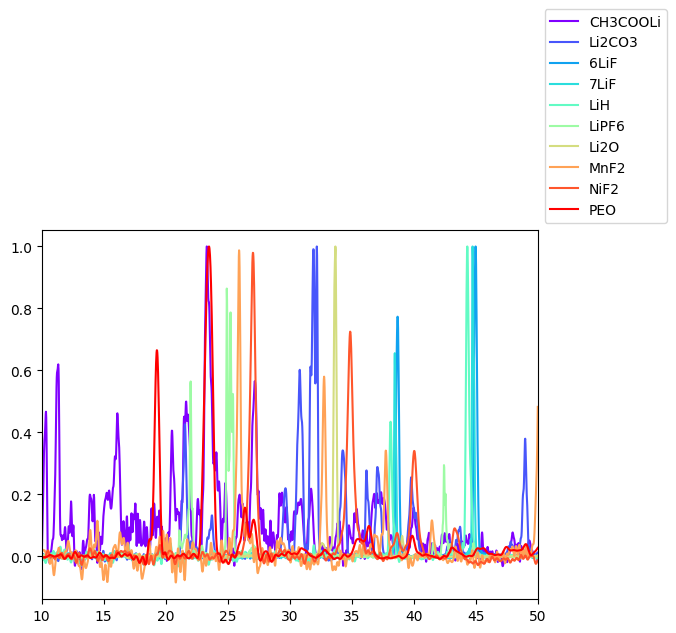

In [ ]:
fig, ax = plt.subplots()
pcol = iter(cm.rainbow(np.linspace(0,1,len(df_dict.keys()))))
for k in df_dict.keys():
  ax.plot(df_dict[k]['2theta'],df_dict[k]['Final'],color=next(pcol),label=k)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlim(10,50)

### Your tasks: QUESTIONS WILL BE SIMILAR TO THIS BUT THIS IS NOT FINAL
1. Come up with a find_peaks procedure that you could run on every one of these XRD patterns to uniquely identify the substance. For full credit on this, you must:
  - Show a find_peaks set of parameters (e.g. distance, threshold, etc.) that can be run on every one of the above XRD patterns and provide enough unique information about each to be informative
    - This can include smoothing if desired.
  - Explain the criteria you would need to use to be certain that the assignment is what you think it is: e.g., needs a peak at 2theta = 25, but cannot have a peak at 2theta = 35.
2. Run the mystery spectra through your find_peaks function and manually evaluate the results. Do your criteria successfully explain the results? If not, can you fix it?
3. Take the data for MnF2. Is there sufficient signal-to-noise to identify this? Why or why not? Is smoothing a good choice for this data?
4. In your opinion, is the XRD data sufficient for determining any mystery material? Why or why not?
5. The backgrounds look very smooth. Does this seem like a good choice? (Hint: look at the paper with the original dataset, and look around on the internet for information about amorphous scattering)

### 7530 only: write a function to check your mystery spectra for identity
I recommend you work in groups of two or three for this. Indicate who you worked with when you turn in the assignment; it is acceptable for your code to be identical with the code of the people indicated. Preferably, your group should include both people who identify as newer to and more experienced with programming. We will talk in class on Wednesday about what this function could look like.